# Facial Emotion Recognition using CNN

- This project implements a deep learning model for facial emotion recognition using the FER2013 dataset, demonstrating advanced techniques in computer vision and machine learning.

## Imports

In [101]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## Parameters

In [ ]:
# Define paths
TRAIN_DIR = "../../data/fer2013/train"
TEST_DIR = "../../data/fer2013/test"
IMG_WIDTH, IMG_HEIGHT = 48, 48
EMOTIONS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

## Class Distribution

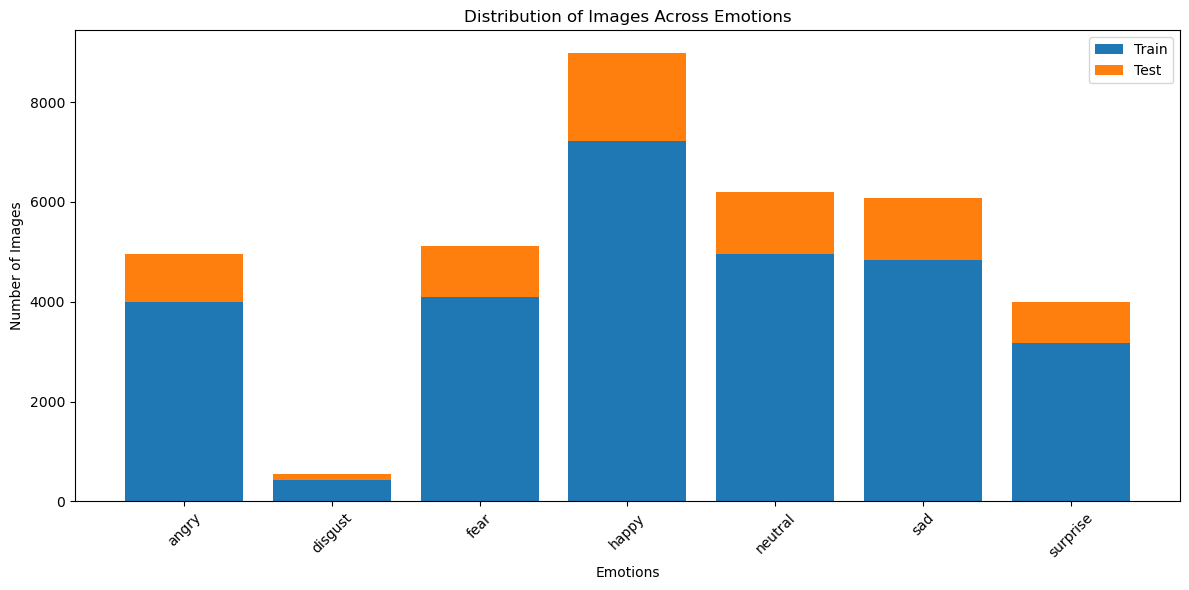

In [103]:
# Count images in each class
train_counts = [
    len(os.listdir(os.path.join(TRAIN_DIR, emotion))) for emotion in EMOTIONS
]
test_counts = [len(os.listdir(os.path.join(TEST_DIR, emotion))) for emotion in EMOTIONS]

# Plot distribution
plt.figure(figsize=(12, 6))
plt.bar(EMOTIONS, train_counts, label="Train")
plt.bar(EMOTIONS, test_counts, bottom=train_counts, label="Test")
plt.title("Distribution of Images Across Emotions")
plt.xlabel("Emotions")
plt.ylabel("Number of Images")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see that the disgust class has significantly few samples compared to the other classes. While there are ways to address this issue, such as through oversampling, undersampling, or synthetic data generation (e.g., SMOTE), for simplicity we just drop the class from the dataset.

In [104]:
# Redefine emotions
EMOTIONS = ["angry", "fear", "happy", "neutral", "sad", "surprise"]

## Data Preprocessing and Augmentation

### Data Augmentation Rationale:
- Reduce overfitting
- Increase training data diversity
- Improve model generalization

In [105]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators (returns batches of (images, labels) pairs during training)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, # normalizes images to 0-1 range (speeds up computation)
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

## Data Generator Creation 

Set up data generators for training, validation, and testing.

In [106]:
BATCH_SIZE = 64

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical", # one-hot encoding
    subset="training",
    classes=EMOTIONS,
    shuffle=True,
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    classes=EMOTIONS,
    shuffle=True,
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=EMOTIONS,
)

Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


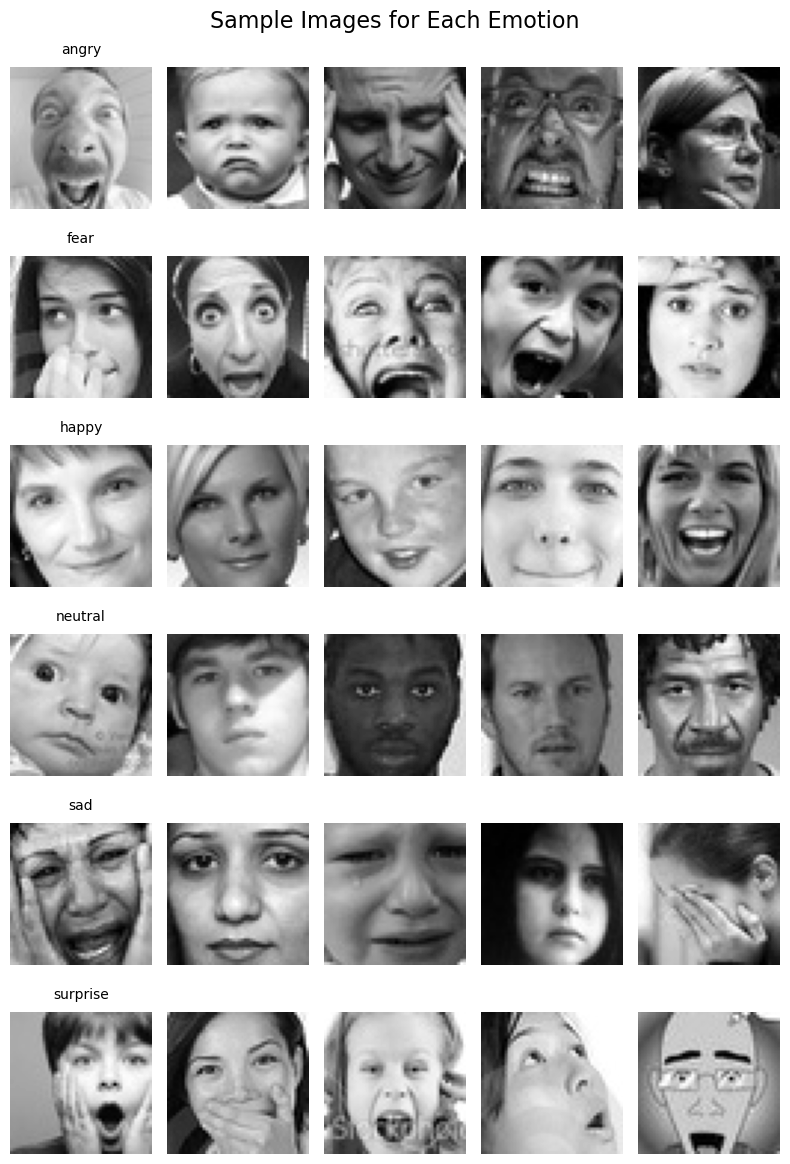

In [107]:
# Display 5 sample images for each emotion
num_samples = 5
fig, axes = plt.subplots(len(EMOTIONS), num_samples, figsize=(8, 12))
axes = axes.ravel()

for i, emotion in enumerate(EMOTIONS):
    emotion_dir = os.path.join(TRAIN_DIR, emotion)
    image_files = os.listdir(emotion_dir)[:num_samples]  # first 5 images

    # Display 5 images for current emotion
    for j, img_file in enumerate(image_files):
        img_path = os.path.join(emotion_dir, img_file)
        img = plt.imread(img_path)

        idx = (i * num_samples) + j
        axes[idx].imshow(img, cmap="gray")

        # add emotion label
        if j == 0:
            axes[idx].set_title(f"{emotion}", fontsize=10, pad=10)
        axes[idx].axis("off")

plt.suptitle("Sample Images for Each Emotion", fontsize=16)
plt.tight_layout()
plt.show()

## CNN Architecture

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dense,
    Dropout,
    Flatten,
    BatchNormalization,
    SpatialDropout2D,
)
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential(
    [
        Input((IMG_WIDTH, IMG_HEIGHT, 1)),
        # Block 1: Initial Feature Extraction
        Conv2D(32, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        SpatialDropout2D(0.2),

        # Block 2: Intermediate Feature Extraction
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        SpatialDropout2D(0.25),

        # Block 3: Advanced Feature Extraction
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        SpatialDropout2D(0.3),

        # Block 4: Advanced Feature Extraction
        Conv2D(256, (3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Classification Block
        Flatten(),
        # First dense layer
        Dense(1024, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        # Intermediate layer
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        # Final dense layer
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        # Output layer
        Dense(len(EMOTIONS), activation="softmax"),
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_9             │ (None, 24, 24, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_10            │ (None, 12, 12, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_11            │ (None, 6, 6, 128)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 3,609,574 (13.77 MB)

 Trainable params: 3,604,582 (13.75 MB)

 Non-trainable params: 4,992 (19.50 KB)

## Model Training

In [112]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 100
callbacks = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callbacks,
)

/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 201s 528ms/step - accuracy: 0.1753 - loss: 2.5678 - val_accuracy: 0.1788 - val_loss: 1.8828
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 88s 248ms/step - accuracy: 0.1959 - loss: 2.2470 - val_accuracy: 0.2559 - val_loss: 1.8114
Epoch 3/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 79s 224ms/step - accuracy: 0.2075 - loss: 2.1177 - val_accuracy: 0.2568 - val_loss: 1.7729
Epoch 4/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 81s 229ms/step - accuracy: 0.2102 - loss: 2.0295 - val_accuracy: 0.2694 - val_loss: 1.7575
Epoch 5/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 87s 244ms/step - accuracy: 0.2151 - loss: 1.9831 - val_accuracy: 0.2649 - val_loss: 1.7509
Epoch 6/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 89s 252ms/step - accuracy: 0.2210 - loss: 1.9310 - val_accuracy: 0.2713 - val_loss: 1.7403
Epoch 7/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - accuracy: 0.2288 - loss: 1.9084 - val_accuracy: 0.2680 - val_loss: 1.7367
Epoch 8/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 323s 913ms/step - accuracy: 0.2341

### Training History Visualization

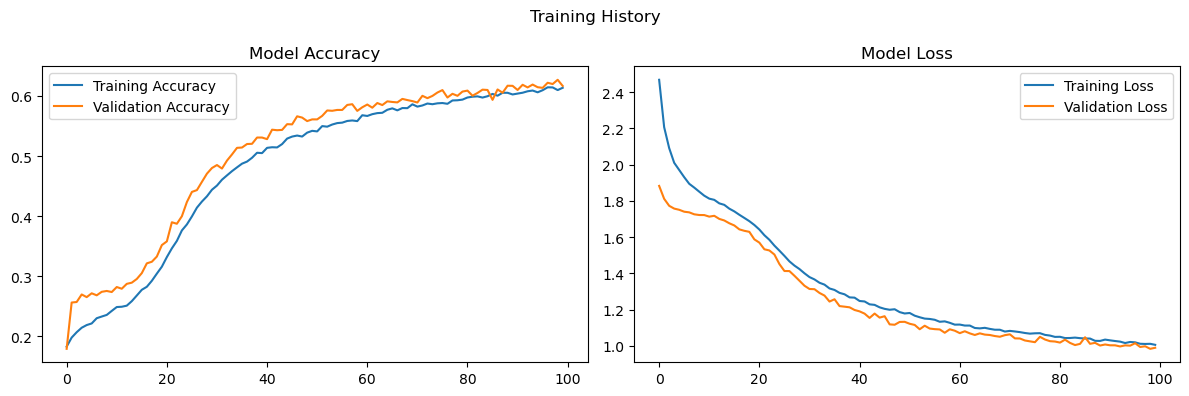

In [113]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axes[0].plot(history.history["accuracy"], label="Training Accuracy")
axes[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
axes[0].set_title("Model Accuracy")
axes[0].legend()

# Loss plot
axes[1].plot(history.history["loss"], label="Training Loss")
axes[1].plot(history.history["val_loss"], label="Validation Loss")
axes[1].set_title("Model Loss")
axes[1].legend()

plt.suptitle("Training History")
plt.tight_layout()
plt.show()

From the training history, we can see that the training and validation accuracy are increasing in tandem. Similarly, the training and validation loss are decreasing in tandem. This indicates that the model is learning effectively and is not overfitting. 

A classic sign of overfitting would be when training accuracy continues to improve while validation accuracy plateaus or declines, or when the training loss keeps decreasing while validation loss starts to increase. In this case, the parallel improvement suggests a healthy learning process.

## Model Evaluation

In [114]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6081 - loss: 0.9950
Test accuracy: 0.6499
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step


### Classification Report

In [115]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=EMOTIONS))

Classification Report:
              precision    recall  f1-score   support

       angry       0.58      0.57      0.58       958
        fear       0.52      0.38      0.44      1024
       happy       0.86      0.86      0.86      1774
     neutral       0.55      0.71      0.62      1233
         sad       0.53      0.48      0.51      1247
    surprise       0.76      0.77      0.76       831

    accuracy                           0.65      7067
   macro avg       0.63      0.63      0.63      7067
weighted avg       0.65      0.65      0.65      7067



The model excels at identifying happy expressions with 86% precision and 86% recall, while struggling significantly with fear, which has only a 38% recall despite 52% precision. Happy and surprise emotions demonstrate the most reliable recognition, whereas sad, angry, and neutral emotions show more moderate performance, with F1-scores ranging between 0.51 and 0.62. This variability suggests that some emotional expressions are more distinctively represented in facial features than others.

The overall accuracy of 65% indicates moderate success in this challenging task of facial emotion recognition. While the model provides valuable insights, there's considerable room for improvement, particularly in distinguishing more subtle or complex emotional states like fear and sadness. 

### Confusion Matrix

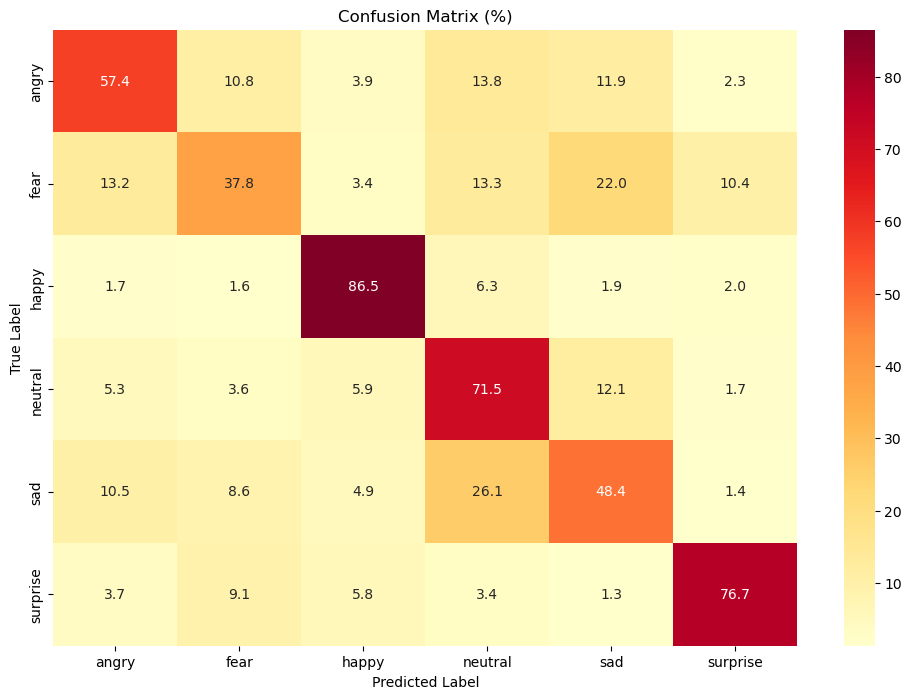

In [116]:
from sklearn.metrics import confusion_matrix

# Plot confusion matrix with percentages
cm = confusion_matrix(y_true, y_pred_classes)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(12, 8))
sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS,
    cmap="YlOrRd",
)
plt.title("Confusion Matrix (%)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### Sample Predictions

In [117]:
# Get a batch of test images and their predictions (for visualization)
test_generator.reset()
batch_x, batch_y = next(test_generator)
predictions = model.predict(batch_x)  # confidence scores for each class for each image

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 


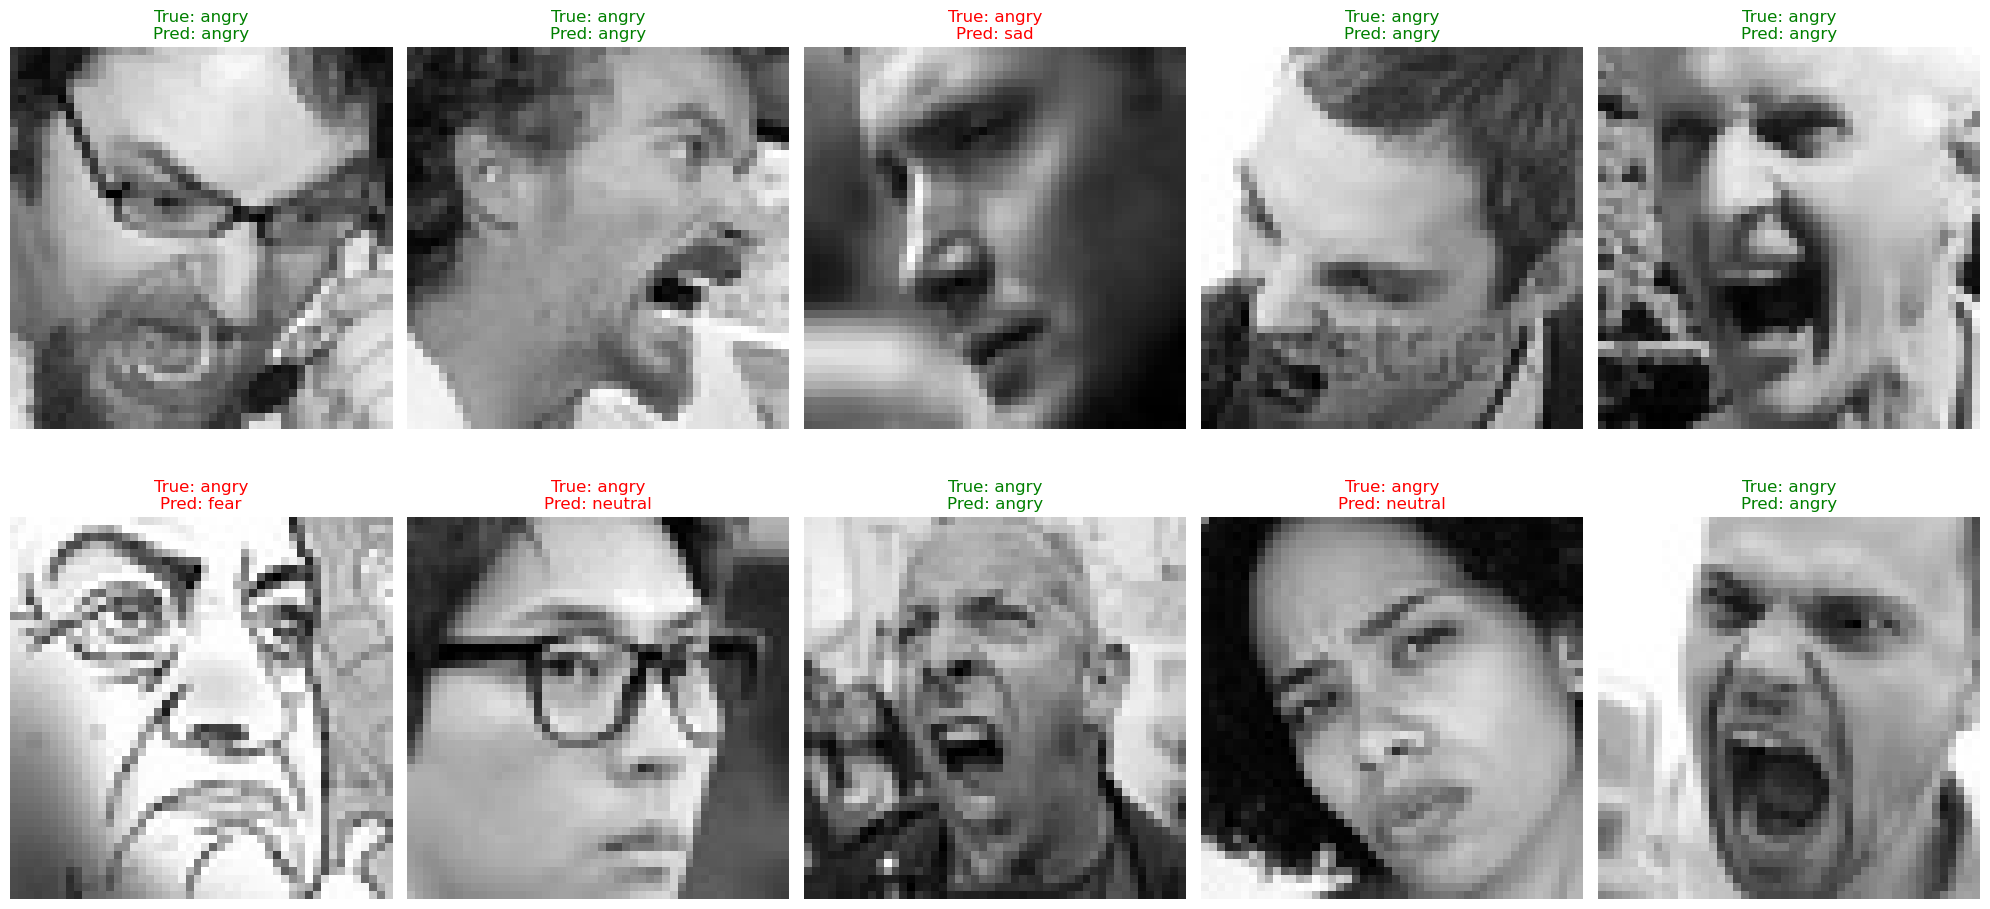

In [118]:
# Plot sample predictions
plt.figure(figsize=(20, 10))
for i in range(min(10, len(batch_x))):
    plt.subplot(2, 5, i + 1)

    # Display image
    plt.imshow(batch_x[i].reshape(IMG_WIDTH, IMG_HEIGHT), cmap="gray")

    # Get true and predicted labels
    true_label = EMOTIONS[np.argmax(batch_y[i])]
    pred_label = EMOTIONS[np.argmax(predictions[i])]

    # Color code the title
    color = "green" if true_label == pred_label else "red"

    # Show prediction probabilities
    probs = [f"{EMOTIONS[j]}: {predictions[i][j]:.2f}" for j in range(len(EMOTIONS))]
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Prediction Confidence

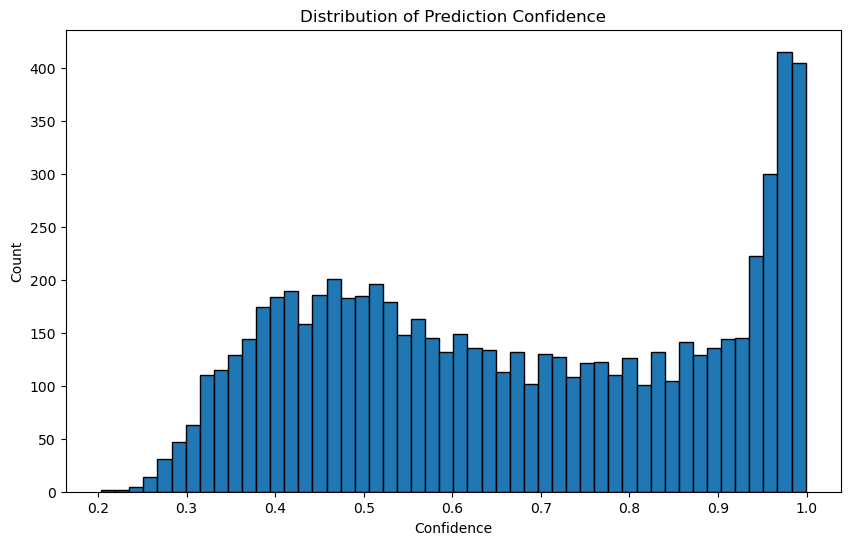

In [119]:
# Plot prediction confidence distribution
plt.figure(figsize=(10, 6))
confidences = np.max(y_pred, axis=1)

plt.hist(confidences, bins=50, edgecolor="black")
plt.title("Distribution of Prediction Confidence")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()

### Top Misclassifications

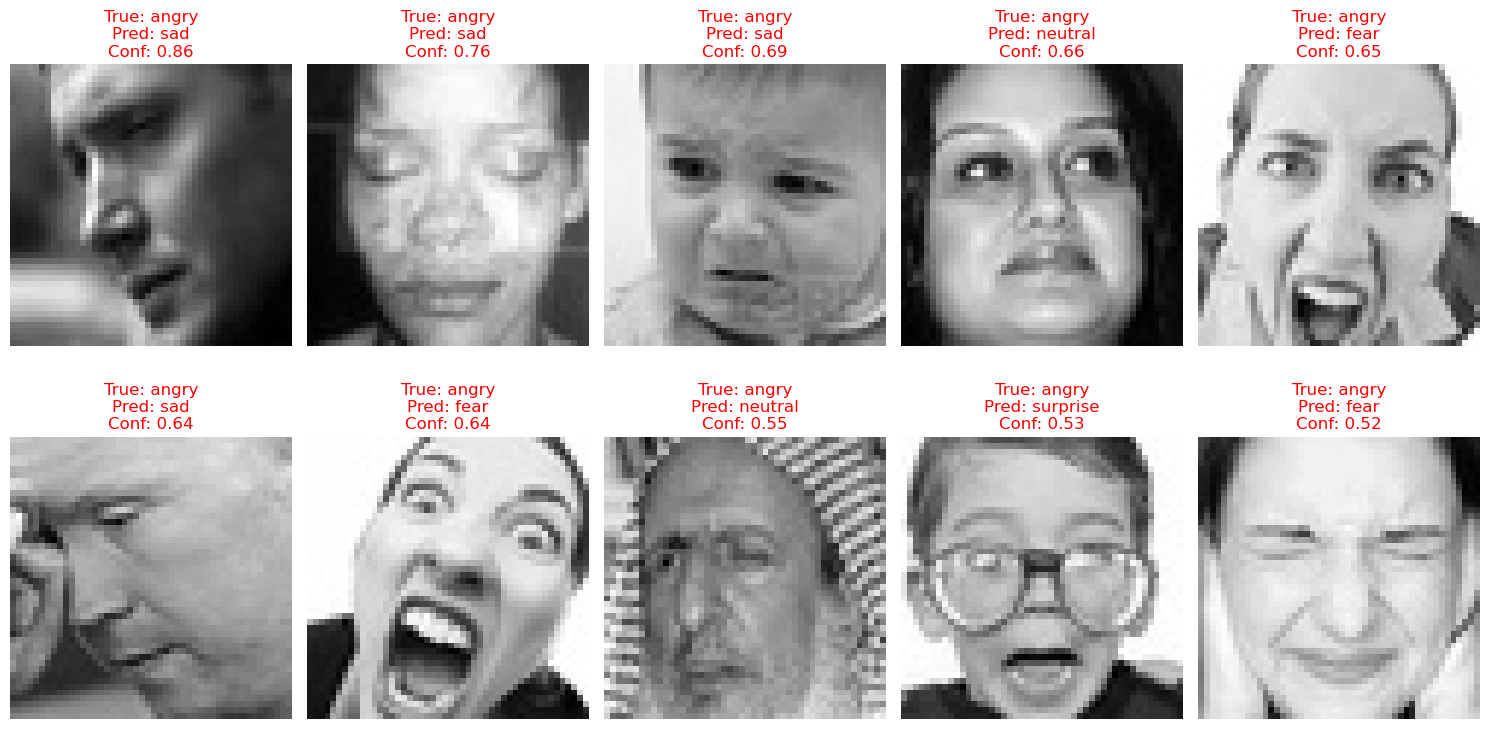

In [120]:
# Plot top misclassifications
def get_top_misclassifications(batch_x, batch_y, predictions, n=5):
    misclass_conf = []
    for i in range(len(batch_x)):
        true_label = np.argmax(batch_y[i])
        pred_label = np.argmax(predictions[i])
        if true_label != pred_label:
            conf = predictions[i][pred_label]
            misclass_conf.append((i, conf, true_label, pred_label))

    return sorted(misclass_conf, key=lambda x: x[1], reverse=True)[:n]


top_misclass = get_top_misclassifications(batch_x, batch_y, predictions, 10)
plt.figure(figsize=(15, 8))
for i, (idx, conf, true_label, pred_label) in enumerate(top_misclass):
    plt.subplot(2, 5, i + 1)
    plt.imshow(batch_x[idx].reshape(IMG_WIDTH, IMG_HEIGHT), cmap="gray")
    plt.title(
        f"True: {EMOTIONS[true_label]}\nPred: {EMOTIONS[pred_label]}\nConf: {conf:.2f}",
        color="red",
    )
    plt.axis("off")
plt.tight_layout()
plt.show()

The consistent misclassification of anger as sadness or fear suggests that these negative emotions share subtle yet crucial facial features that the model struggles to differentiate. This pattern indicates that the model's convolutional layers may not be capturing the nuanced muscular distinctions between anger, sadness, and fear.

From a psychological and computer vision perspective, this makes sense. Anger, sadness, and fear can involve similar facial muscle tensions, particularly around the eyes and forehead. The key differentiators might be extremely subtle – perhaps in the exact curvature of eyebrows, the specific tension of facial muscles, or micro-expressions that are challenging for the model to learn. This misclassification pattern suggests that our model would benefit from more sophisticated feature extraction techniques, potentially incorporating more advanced attention mechanisms or using transfer learning from models trained on more extensive emotion datasets.